We wanted to explore data supplied by Stroud District Council's speed cameras.

[Description of data](https://docs.google.com/document/d/1xVO0mt2aCurYc5V10tUA0N-1gr3RsQ0jhXqBO_wltYk/edit) here, with some important questions and assumptions.

We have 9,162,911 rows of raw data, from 7 different signal locations.

## Clean and examine the data

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [2]:
df_raw = pd.read_csv('./data.csv', low_memory=False)
print("We have %s rows of data" % len(df_raw))

We have 9162911 rows of data


In [69]:
# Ignore the header rows that got included accidentally!
df = df_raw[df_raw.date != 'Date']

In [70]:
df.head()

,status,location,date,speed,direction
1,off.csv,Down Bisley Old Road Jan 2018.csv,28/01/2019 14:39:19,24,Arriving
2,off.csv,Down Bisley Old Road Jan 2018.csv,28/01/2019 14:39:21,25,Arriving
3,off.csv,Down Bisley Old Road Jan 2018.csv,28/01/2019 14:39:22,25,Arriving
4,off.csv,Down Bisley Old Road Jan 2018.csv,28/01/2019 14:39:51,23,Arriving
5,off.csv,Down Bisley Old Road Jan 2018.csv,28/01/2019 14:40:00,19,Arriving


The direction column doesn't seem to do anything interesting, so get rid of it. 

In [61]:
df.direction.value_counts()

Arriving    9162874
Name: direction, dtype: int64

In [ ]:
del df['direction']

### Standardise the locations

Tidy up, and examine, the location names. These are based on filenames and a bit messy.

In [71]:
def clean_location_name(name):
    name = name.split()[:2]
    name = ' '.join(name).replace(' Speed data', '')
    name = name.replace('London Road London Road', 'London Road')
    name = name.replace('Parliament Street', 'Parliament St')
    name = name.replace('Down Parliamnet', 'Down Parliament')
    return name

df['location_clean'] = df.location.apply(clean_location_name)

In [26]:
df.location_clean.value_counts()

London Road        2681184
Down Parliament    2150895
Up Bisley          1901311
Slad Road           759208
Stratford Road      739591
Up Parliament       490639
Down Bisley         440046
Name: location_clean, dtype: int64

### Sort the column types

In [72]:
df.dtypes

status            object
location          object
date              object
speed             object
direction         object
location_clean    object
dtype: object

Clean up the status values. TODO: Find out what "off_new" status indicates, but for the moment, assume it means off. 

In [37]:
df.status.value_counts()

off.csv        4105931
on.csv         3591301
off_new.csv    1465642
Name: status, dtype: int64

In [98]:
def off_or_on(s):
    if s.startswith('off'):
        return 'off'
    return 'on'
df['status_clean'] = df.status.apply(off_or_on)
df.status_clean.value_counts()

off    5571573
on     3591301
Name: status_clean, dtype: int64

Cast the numeric and date columns. This takes a while.

In [73]:
df['speed_numeric'] = pd.to_numeric(df.speed)

In [88]:
# Slooooooow!
# Input format is 12/02/2019 00:05:24
df['date_clean'] = pd.to_datetime(df.date, format='%d/%m/%Y %H:%M:%S')

In [83]:
# This will be useful if we want to look at speeding by time of day etc.
df['day'] = df.date_clean.dt.day
df['hour'] = df.date_clean.dt.hour
df['dayofweek'] = df.date_clean.dt.dayofweek
df['hourofweek'] = (df.dayofweek + 1) * (df.hour + 1)

## Some preliminary observations

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c544b50>]],
      dtype=object)

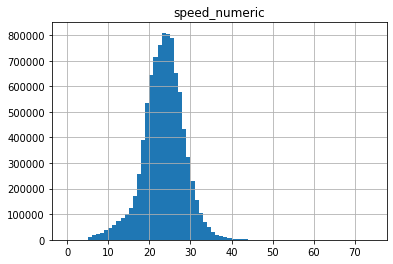

In [39]:
# Eyeball the overall speed distribution.
df.hist(column='speed_numeric', bins=range(0, 75))

In [ ]:
# How many observations do we have for each location, over time?
df['month_year'] = df.date_clean.apply(lambda x: x.strftime('%Y-%m')) 
location_by_month = df.groupby([df.month_year, df.location_clean]).count().status

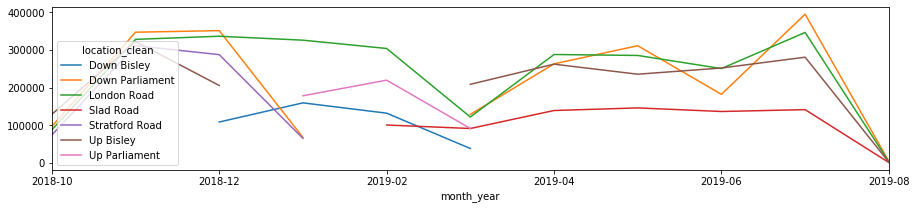

In [95]:
# There are some discontinuities in the data - London Road is the only location with continuous data.
location_by_month.unstack().plot(kind="line", figsize=[15,3])

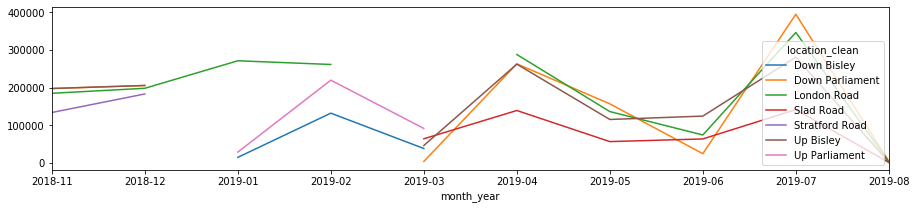

In [99]:
# How does the "off" data look.
location_by_month_off = df[df.status_clean=="off"].groupby([df.month_year, df.location_clean]).count().status
location_by_month_off.unstack().plot(kind="line", figsize=[15,3])

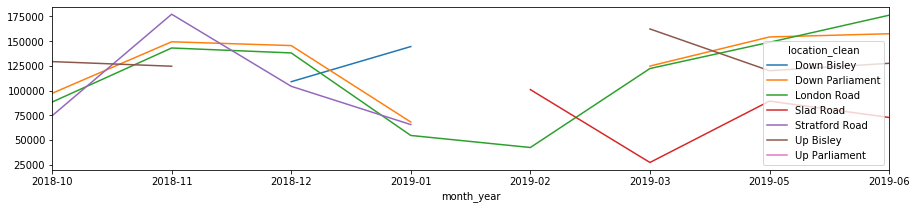

In [100]:
# How does the "on" data look.
location_by_month_on = df[df.status_clean=="on"].groupby([df.month_year, df.location_clean]).count().status
location_by_month_on.unstack().plot(kind="line", figsize=[15,3])

## Get mean speed by signal status

Very crude! But looks how we might hope. TODO: Ask Tim how `off.csv` or `off_new.csv` are different?

In [40]:
df.groupby('status_clean').mean()['speed_numeric']

status_clean
off    23.339455
on     22.334460
Name: speed_numeric, dtype: float64

## Speeding by time of day / day of week

Kim asks: "I’d love to know if there are particular times of day or night when speeding is high so that we can ask the police to target their activity."

These answers are crude, just poking the data to see how it looks. Would want to break this down by location.

In [41]:
# High-level mean speed by day of week (not very interesting)
df.groupby('dayofweek').mean()['speed_numeric']

dayofweek
0    23.013746
1    22.924429
2    22.881452
3    22.842404
4    22.895516
5    22.907169
6    23.197996
Name: speed_numeric, dtype: float64

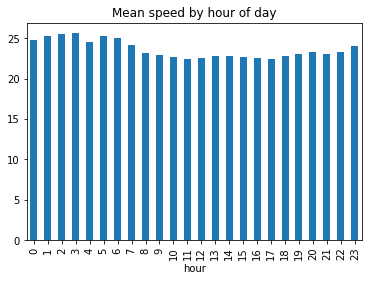

In [42]:
# High-level mean speed by hour of day
speed_by_hour_of_day = df.groupby('hour').mean()['speed_numeric']
speed_by_hour_of_day.plot(kind='bar', title ="Mean speed by hour of day")

In [43]:
speed_by_hour_of_week = df.groupby('hourofweek').mean()['speed_numeric']

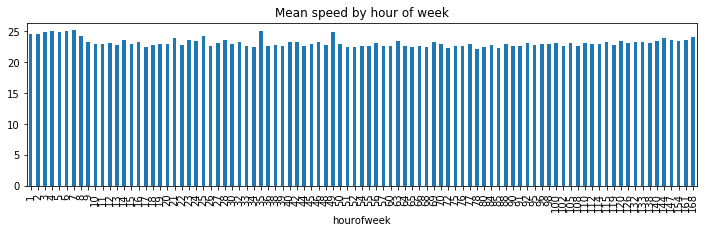

In [62]:
# Assume those bumps are noise, but maybe worth a look?
speed_by_hour_of_week.plot(kind='bar', title ="Mean speed by hour of week", figsize=[12,3])

Is this different depending on whether the things are on or off? Just eyeballing the data here.

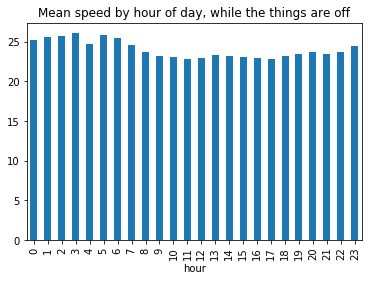

In [48]:
speed_by_hour_of_day_off = df[df.status_clean=='off'].groupby('hour').mean()['speed_numeric']
speed_by_hour_of_day_off.plot(kind='bar', title ="Mean speed by hour of day, while the things are off")

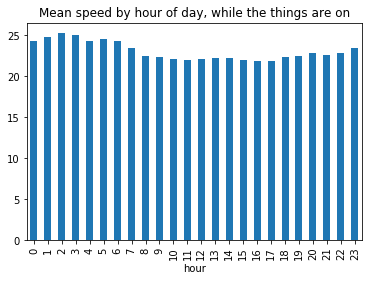

In [49]:
speed_by_hour_of_day_on = df[df.status_clean=='on'].groupby('hour').mean()['speed_numeric']
speed_by_hour_of_day_on.plot(kind='bar', title ="Mean speed by hour of day, while the things are on")

## Highest and lowest speeds recorded

In [52]:
# All speeds over 60mph, grouped by location.
df[df.speed_numeric>60].groupby('location_clean').count().sort_values(by='status', ascending=False)['status']

location_clean
London Road        47
Down Parliament    13
Up Bisley           9
Down Bisley         4
Slad Road           1
Name: status, dtype: int64

London Road is the top mega-speeding spot, possibly just because there's more data in this location. What time of day do people speed most?

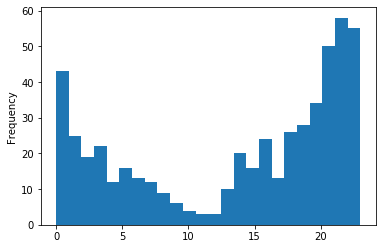

In [53]:
df2 = df[(df.speed_numeric>50) & (df.location_clean == 'London Road')]
df2.hour.plot(kind='hist', bins=24)

What does the raw London Road data look like? Note that there appear to be some duplicate observations in here.

In [56]:
df[(df.speed_numeric>60) & (df.location_clean == 'London Road')].sort_values('date_clean')

,status,location,date,speed,location_clean,speed_numeric,date_clean,day,hour,dayofweek,hourofweek,status_clean
2213273,off.csv,London Road Nov 2018.csv,06/12/2018 02:31:31,63,London Road,63,2018-06-12 02:31:31,12,2,1,6,off
2213277,off.csv,London Road Nov 2018.csv,06/12/2018 02:32:16,63,London Road,63,2018-06-12 02:32:16,12,2,1,6,off
7425180,on.csv,London Road October 2018.csv,26/10/2018 01:45:04,61,London Road,61,2018-10-26 01:45:04,26,1,4,10,on
7425181,on.csv,London Road October 2018.csv,26/10/2018 01:45:06,66,London Road,66,2018-10-26 01:45:06,26,1,4,10,on
7481414,on.csv,London Road October 2018.csv,31/10/2018 04:08:00,61,London Road,61,2018-10-31 04:08:00,31,4,2,15,on
7481415,on.csv,London Road October 2018.csv,31/10/2018 04:08:01,65,London Road,65,2018-10-31 04:08:01,31,4,2,15,on
7493428,on.csv,London Road October 2018.csv,31/10/2018 22:18:50,61,London Road,61,2018-10-31 22:18:50,31,22,2,69,on
7493429,on.csv,London Road October 2018.csv,31/10/2018 22:18:51,68,London Road,68,2018-10-31 22:18:51,31,22,2,69,on
7615920,on.csv,London Road October 2018.csv,13/11/2018 05:43:22,64,London Road,64,2018-11-13 05:43:22,13,5,1,12,on
2014198,off.csv,London Road Nov 2018.csv,18/11/2018 04:35:22,62,London Road,62,2018-11-18 04:35:22,18,4,6,35,off


What are the slowest speeds recorded? There appears to be a floor of 5mph.

In [58]:
df.nsmallest(100, 'speed_numeric')

,status,location,date,speed,location_clean,speed_numeric,date_clean,day,hour,dayofweek,hourofweek,status_clean
19129,off.csv,Down Bisley Old Road Jan 2018.csv,02/02/2019 13:43:01,5,Down Bisley,5,2019-02-02 13:43:01,2,13,5,84,off
19493,off.csv,Down Bisley Old Road Jan 2018.csv,02/02/2019 14:32:51,5,Down Bisley,5,2019-02-02 14:32:51,2,14,5,90,off
22296,off.csv,Down Bisley Old Road Jan 2018.csv,03/02/2019 11:32:07,5,Down Bisley,5,2019-03-02 11:32:07,2,11,5,72,off
22395,off.csv,Down Bisley Old Road Jan 2018.csv,03/02/2019 11:44:54,5,Down Bisley,5,2019-03-02 11:44:54,2,11,5,72,off
27183,off.csv,Down Bisley Old Road Jan 2018.csv,04/02/2019 14:48:12,5,Down Bisley,5,2019-04-02 14:48:12,2,14,1,30,off
27220,off.csv,Down Bisley Old Road Jan 2018.csv,04/02/2019 14:55:07,5,Down Bisley,5,2019-04-02 14:55:07,2,14,1,30,off
32903,off.csv,Down Bisley Old Road Jan 2018.csv,05/02/2019 17:17:45,5,Down Bisley,5,2019-05-02 17:17:45,2,17,3,72,off
50368,off.csv,Down Bisley Old Road Jan 2018.csv,09/02/2019 14:04:31,5,Down Bisley,5,2019-09-02 14:04:31,2,14,0,15,off
57620,off.csv,Down Bisley Old Road Jan 2018.csv,11/02/2019 12:35:53,5,Down Bisley,5,2019-11-02 12:35:53,2,12,5,78,off
62742,off.csv,Down Bisley Old Road Jan 2018.csv,12/02/2019 14:02:54,5,Down Bisley,5,2019-12-02 14:02:54,2,14,0,15,off


In [96]:
# Extract the top speeds to a new file, for potential mapping.
df[df.speed_numeric>50].to_csv('top_speeds.csv', index=False)